In [78]:
import os
import re

import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Bidirectional
from keras.layers import SpatialDropout1D
from gensim.models import Word2Vec
from keras.utils import np_utils
from keras.preprocessing import sequence
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from keras.regularizers import l2
import seaborn as sns
from gensim.models import KeyedVectors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from matplotlib import colors

import config


In [13]:
w2v_path = os.path.join("word_embedding", "ruwikiruscorpora-nobigrams_upos_skipgram_300_5_2018.vec.gz")
hh_data_path = os.path.join("headHunter_data", "hh_dataset.csv")

In [10]:
dataset_hh = pd.read_csv(hh_data_path, sep="\t")

In [11]:
dataset_hh.head()

,id,lang_title,requirement,requirement_lemmas,requirement_lemmas_tags,requirement_norm,requirement_tokens,responsibility,responsibility_lemmas,responsibility_lemmas_tags,...,title_tokens,url,lang_text,profarea_names,specializations,text,text_lemmas,text_lemmas_tags,text_normalized,text_tokens
0,29103667,russian,Высшее (желательно техническое) образование. П...,высший желательный технический образование lot...,высший_ADJ желательный_ADJ технический_ADJ обр...,высш желательн техническ образован lotus хорош...,высшее желательно техническое образование lotu...,Ежедневное планирование работы завода (молочно...,ежедневный планирование работа завод молочный ...,ежедневный_ADJ планирование_NOUN работа_NOUN з...,...,специаидать_NOUN планирование_NOUN производств...,https://api.hh.ru/vacancies/29103667?host=hh.ua,russian,"['Производство', 'Закупки']","['Пищевая промышленность', 'Управление закупка...",<p><strong>Международная компания – крупнейший...,международный компания крупнейший производител...,международный_ADJ компания_NOUN крупнейший_ADJ...,международн компан крупн производител свеж мол...,международный_ADJ компания_NOUN крупнейший_ADJ...
1,29103666,russian,Умение работать в коллективе. Образование не н...,умение работать коллектив образование ниже тех...,умение_NOUN работать_VERB коллектив_NOUN образ...,умен работа коллектив образован ниж техническ ...,умение работать коллективе образование ниже те...,Техническая подготовка выполнения сварочных ра...,технический подготовка выполнение сварочный ра...,технический_ADJ подготовка_NOUN выполнение_NOU...,...,главный_ADJ сварщик_NOUN,https://api.hh.ru/vacancies/29103666?host=hh.ua,russian,['Рабочий персонал'],['Сварщик'],<strong>Обязанности:</strong> <ul> <li><em>Тех...,обязанность технический подготовка выполнение ...,обязанность_NOUN технический_ADJ подготовка_NO...,обязан техническ подготовк выполнен сварочн ра...,обязанность_NOUN технический_ADJ подготовка_NO...
2,29103665,russian,At least a bachelor degree in Computer Science...,least bachelor degree computer science master ...,least bachelor degree computer science master ...,least bachelor degre comput scienc master degr...,least bachelor degree computer science master ...,Contributes to product and performance improve...,contributes product performance improvement op...,contributes product performance improvement op...,...,java_X developer_X,https://api.hh.ru/vacancies/29103665?host=hh.ua,english,"['Информационные технологии, интернет, телеком']","['Программирование, Разработка']",<p>Role:<br />Contributes to product and perfo...,role contributes product performance improveme...,role contributes product performance improveme...,role contribut product perform improv optim ex...,role contributes product performance improveme...
3,29103664,russian,Профильное высшее образование (Художественное/...,профильный высший образование креативность нес...,профильный_ADJ высший_ADJ образование_NOUN кре...,профильн высш образован креативн нестандартн м...,профильное высшее образование креативность нес...,Дизайн и верстка еженедельного акционного букл...,дизайн верстка еженедельный акциоть буклет раз...,дизайн_NOUN верстка_NOUN еженедельный_ADJ акци...,...,дизайнер_NOUN,https://api.hh.ru/vacancies/29103664?host=hh.ua,russian,"['Искусство, развлечения, масс-медиа', 'Маркет...","['Дизайн, графика, живопись', 'Дизайнер']",<p><strong>Сеть гипермаркетов ProStore приглаш...,сеть гипермаркет prostore приглашать постоянны...,сеть_NOUN гипермаркет_NOUN prostore_X приглаша...,сет гипермаркет prostor приглаша постоя работ ...,сеть_NOUN гипермаркет_NOUN prostore_X приглаша...
4,29103661,russian,1. Высшее образование ( в приоритете: менеджме...,высший образование приоритет менеджмент маркет...,высший_ADJ образование_NOUN приоритет_VERB мен...,высш образован приоритет менеджмент маркетинг ...,высшее образование приоритете менеджмент марке...,Наша студия помогает компаниям повышать продаж...,наш студия помогать компания повышать продажа ...,наш_DET студия_N

In [12]:
dataset_hh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3653 entries, 0 to 3652
Data columns (total 26 columns):
id                            3653 non-null int64
lang_title                    3653 non-null object
requirement                   3536 non-null object
requirement_lemmas            3536 non-null object
requirement_lemmas_tags       3536 non-null object
requirement_norm              3536 non-null object
requirement_tokens            3536 non-null object
responsibility                3472 non-null object
responsibility_lemmas         3472 non-null object
responsibility_lemmas_tags    3472 non-null object
responsibility_norm           3472 non-null object
responsibility_tokens         3472 non-null object
title                         3653 non-null object
title_lemmas                  3335 non-null object
title_lemmas_tags             3335 non-null object
title_normalized              3335 non-null object
title_tokens                  3335 non-null object
url                        

In [15]:
vectorizer = KeyedVectors.load_word2vec_format(w2v_path, binary=False)


In [98]:
documents = [row["requirement_lemmas_tags"] for _, row in dataset_hh.iterrows()
             if isinstance(row["requirement_lemmas_tags"], str)]

In [99]:
documents[0]

'высший_ADJ желательный_ADJ технический_ADJ образование_NOUN lotus_X хороший_ADJ знание_NOUN excel_X английский_ADJ elementary_X опционально_ADV ответственность_NOUN умение_NOUN аналитически_ADV мыслить_VERB умение_NOUN общаться_VERB'

In [107]:
vectorizer_tfidf = TfidfVectorizer(min_df=1, max_df=0.5, ngram_range=(1, 2))
X = vectorizer_tfidf.fit_transform(documents).todense()

In [ ]:
true_k = 2
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

In [ ]:
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer_tfidf.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print()

In [104]:
print(model.predict(X[0]))
print(dataset_hh.loc[0, "profarea_names"])

"['Производство', 'Закупки']"

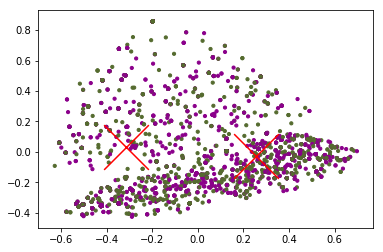

In [105]:
col_list = list(colors.cnames.keys())
print(len(col_list))

pca = PCA(n_components=2).fit(X)
data2D = pca.transform(X)
plt.scatter(data2D[:,0], data2D[:,1], c=col_list[28:30], s=10)

centers2D = pca.transform(model.cluster_centers_)
plt.scatter(centers2D[:,0], centers2D[:,1], 
            marker='x', s=2000, linewidths=3, c='r', )
plt.show()            